Loading dataset...


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Creating model...


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fine-tuning model...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/3: 100%|██████████| 563/563 [07:55<00:00,  1.18it/s]


Epoch 1/3, Average Loss: 0.0014
Validation - Loss: 0.0000, Accuracy: 1.0000


Epoch 2/3: 100%|██████████| 563/563 [08:11<00:00,  1.15it/s]


Epoch 2/3, Average Loss: 0.0000
Validation - Loss: 0.0000, Accuracy: 1.0000


Epoch 3/3: 100%|██████████| 563/563 [08:11<00:00,  1.15it/s]


Epoch 3/3, Average Loss: 0.0000
Validation - Loss: 0.0000, Accuracy: 1.0000
Identifying useless parameters...


Gradient Analysis: 100%|██████████| 63/63 [00:51<00:00,  1.23it/s]


Visualizing results...
Total parameters: 124,441,344
Identified useless parameters: 119,751,065 (96.23%)


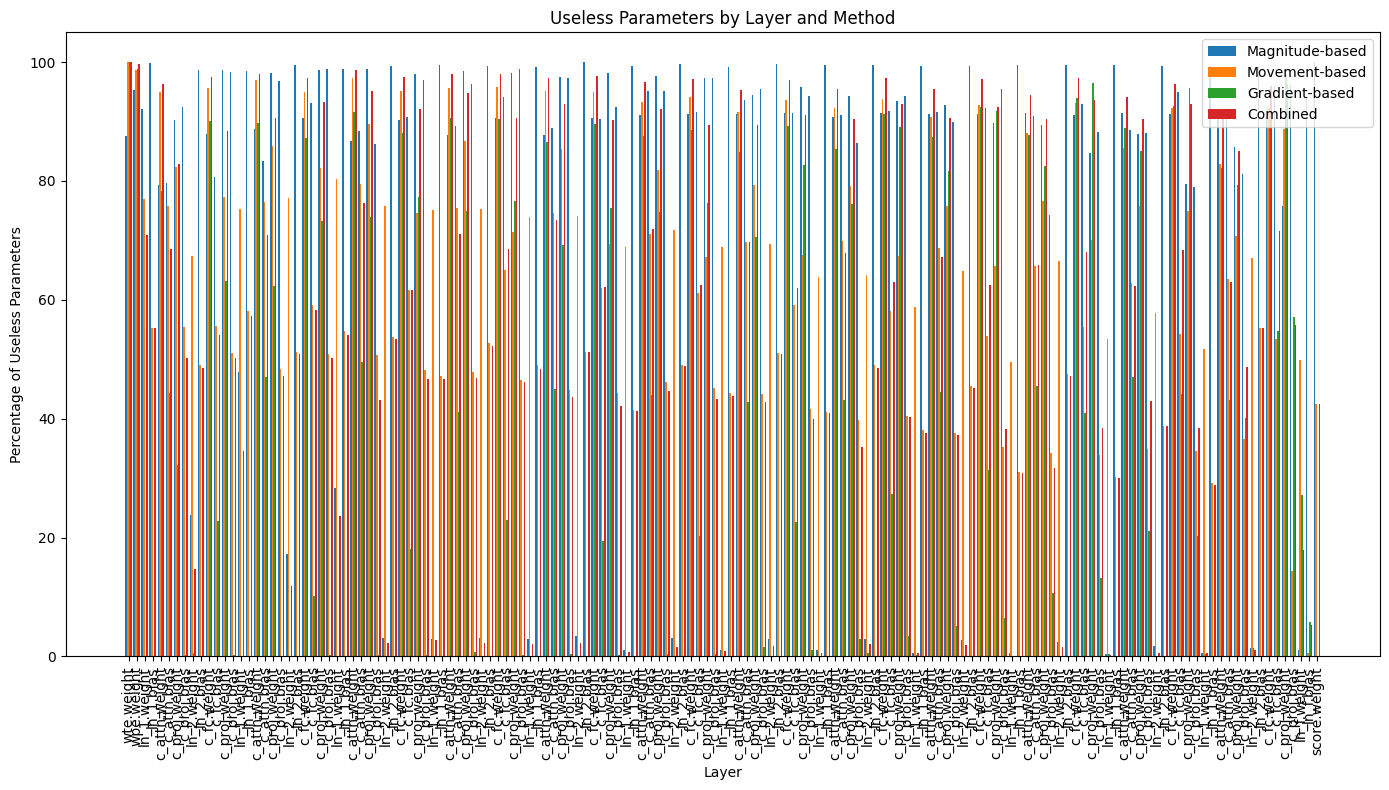

Magnitude threshold: 0.217211
Movement threshold: 0.000416
Gradient threshold: 0.000000

Top 10 layers with highest percentage of useless parameters:
1. transformer.wte.weight: 100.00% useless
2. transformer.wpe.weight: 99.71% useless
3. transformer.h.2.attn.c_attn.weight: 98.59% useless
4. transformer.h.3.attn.c_attn.weight: 98.06% useless
5. transformer.h.3.mlp.c_fc.weight: 97.96% useless
6. transformer.h.1.attn.c_attn.weight: 97.92% useless
7. transformer.h.4.mlp.c_fc.weight: 97.67% useless
8. transformer.h.2.mlp.c_fc.weight: 97.52% useless
9. transformer.h.0.mlp.c_fc.weight: 97.46% useless
10. transformer.h.1.mlp.c_fc.weight: 97.40% useless

Analysis complete. Model and useless parameters saved for future unlearning.


In [1]:
import torch
import numpy as np
from transformers import GPT2Model, GPT2Config, GPT2ForSequenceClassification, GPT2Tokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset, random_split
from datasets import load_dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# 1. Load and prepare dataset (using IMDb for sentiment analysis)
def prepare_dataset():
    print("Loading dataset...")
    dataset = load_dataset("imdb")
    
    # Create a custom dataset class for easier handling
    class IMDbDataset(Dataset):
        def __init__(self, texts, labels, tokenizer, max_length=512):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_length = max_length
            
        def __len__(self):
            return len(self.labels)
            
        def __getitem__(self, idx):
            text = self.texts[idx]
            label = self.labels[idx]
            
            # Tokenize the text
            encoding = self.tokenizer(
                text,
                truncation=True,
                max_length=self.max_length,
                padding="max_length",
                return_tensors="pt"
            )
            
            # Convert to the expected format
            input_ids = encoding["input_ids"].squeeze()
            attention_mask = encoding["attention_mask"].squeeze()
            
            return {
                "input_ids": input_ids,
                "attention_mask": attention_mask,
                "labels": torch.tensor(label, dtype=torch.long)
            }
    
    # Setup tokenizer with proper padding
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    tokenizer.pad_token = tokenizer.eos_token
    
    # Create train and validation sets
    train_texts = dataset["train"]["text"][:5000]  # Using a subset for faster training
    train_labels = dataset["train"]["label"][:5000]
    
    # Create dataset with pre-tokenized inputs
    train_dataset = IMDbDataset(train_texts, train_labels, tokenizer)
    
    # Split into train and validation
    train_size = int(0.9 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
    
    return train_dataset, val_dataset, tokenizer

# 2. Define model and tokenizer
def create_model(tokenizer, num_labels=2):
    print("Creating model...")
    # Load pre-trained GPT-2 (small version)
    config = GPT2Config.from_pretrained("gpt2", num_labels=num_labels)
    model = GPT2ForSequenceClassification.from_pretrained("gpt2", config=config)
    
    # Set pad token id in the model config
    model.config.pad_token_id = tokenizer.pad_token_id
    
    # Save the initial model state for later comparison
    initial_state = {name: param.clone().detach() for name, param in model.named_parameters()}
    
    return model, initial_state

# 3. Fine-tune the model
def finetune_model(model, train_dataset, val_dataset, epochs=3, batch_size=8):
    print("Fine-tuning model...")
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Setup optimizer and learning rate scheduler
    optimizer = AdamW(model.parameters(), lr=5e-5)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=total_steps
    )
    
    # Setup device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                labels=batch["labels"]
            )
            
            loss = outputs.loss
            total_loss += loss.item()
            
            # Backward pass
            loss.backward()
            optimizer.step()
            scheduler.step()
        
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}")
        
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                
                outputs = model(
                    input_ids=batch["input_ids"],
                    attention_mask=batch["attention_mask"],
                    labels=batch["labels"]
                )
                
                val_loss += outputs.loss.item()
                
                # Get predictions
                logits = outputs.logits
                predictions = torch.argmax(logits, dim=1)
                correct += (predictions == batch["labels"]).sum().item()
                total += batch["labels"].size(0)
        
        val_accuracy = correct / total
        print(f"Validation - Loss: {val_loss/len(val_loader):.4f}, Accuracy: {val_accuracy:.4f}")
    
    return model, val_loader

# 4. Identify useless parameters using multiple methods
def identify_useless_parameters(model, initial_state, val_loader):
    print("Identifying useless parameters...")
    device = next(model.parameters()).device
    
    # Method 1: Magnitude-based pruning
    def magnitude_based_pruning(model, percentile=90):
        param_magnitudes = {}
        for name, param in model.named_parameters():
            if param.requires_grad:
                param_magnitudes[name] = torch.abs(param).detach().cpu().numpy().flatten()
        
        # Calculate threshold based on percentile
        all_magnitudes = np.concatenate([mag for mag in param_magnitudes.values()])
        threshold = np.percentile(all_magnitudes, percentile)
        
        useless_params = {}
        for name, magnitudes in param_magnitudes.items():
            useless_params[name] = magnitudes < threshold
        
        return useless_params, threshold
    
    # Method 2: Movement-based analysis
    def movement_based_analysis(model, initial_state, percentile=90):
        param_movements = {}
        for name, param in model.named_parameters():
            if param.requires_grad and name in initial_state:
                movement = torch.abs(param - initial_state[name].to(param.device)).detach().cpu().numpy().flatten()
                param_movements[name] = movement
        
        # Calculate threshold based on percentile
        all_movements = np.concatenate([mov for mov in param_movements.values()])
        threshold = np.percentile(all_movements, percentile)
        
        useless_params = {}
        for name, movements in param_movements.items():
            useless_params[name] = movements < threshold
        
        return useless_params, threshold
    
    # Method 3: Gradient-based analysis
    def gradient_based_analysis(model, val_loader, percentile=90):
        # Initialize gradient accumulation
        grad_accumulation = {}
        for name, param in model.named_parameters():
            if param.requires_grad:
                grad_accumulation[name] = torch.zeros_like(param)
        
        # Accumulate gradients over validation set
        model.eval()
        num_samples = 0
        
        for batch in tqdm(val_loader, desc="Gradient Analysis"):
            batch = {k: v.to(device) for k, v in batch.items()}
            
            model.zero_grad()
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                labels=batch["labels"]
            )
            
            loss = outputs.loss
            loss.backward()
            
            # Accumulate absolute gradients
            for name, param in model.named_parameters():
                if param.requires_grad and param.grad is not None:
                    grad_accumulation[name] += torch.abs(param.grad).detach()
            
            num_samples += 1
        
        # Average gradients
        for name in grad_accumulation:
            grad_accumulation[name] /= num_samples
            
        # Convert to numpy and flatten
        grad_magnitudes = {name: grad.cpu().numpy().flatten() for name, grad in grad_accumulation.items()}
        
        # Calculate threshold based on percentile
        all_grads = np.concatenate([grad for grad in grad_magnitudes.values()])
        threshold = np.percentile(all_grads, percentile)
        
        useless_params = {}
        for name, grads in grad_magnitudes.items():
            useless_params[name] = grads < threshold
        
        return useless_params, threshold
    
    # Apply all methods
    magnitude_results, mag_threshold = magnitude_based_pruning(model)
    movement_results, mov_threshold = movement_based_analysis(model, initial_state)
    gradient_results, grad_threshold = gradient_based_analysis(model, val_loader)
    
    # Combine results (a parameter is considered useless if identified by at least 2 methods)
    combined_results = {}
    parameter_stats = {}
    
    for name in magnitude_results:
        if name in movement_results and name in gradient_results:
            # Calculate percentage of parameters identified as useless by each method
            mag_percent = np.mean(magnitude_results[name]) * 100
            mov_percent = np.mean(movement_results[name]) * 100
            grad_percent = np.mean(gradient_results[name]) * 100
            
            # Parameter is useless if identified by at least 2 methods
            combined_mask = (magnitude_results[name].astype(int) + 
                            movement_results[name].astype(int) + 
                            gradient_results[name].astype(int)) >= 2
            
            combined_results[name] = combined_mask
            parameter_stats[name] = {
                "magnitude_percent": mag_percent,
                "movement_percent": mov_percent,
                "gradient_percent": grad_percent,
                "combined_percent": np.mean(combined_mask) * 100
            }
    
    return combined_results, parameter_stats, (mag_threshold, mov_threshold, grad_threshold)

# 5. Visualize results
def visualize_results(model, parameter_stats, thresholds):
    print("Visualizing results...")
    # Calculate total parameters and useless parameters
    total_params = 0
    useless_params = 0
    
    for name, stats in parameter_stats.items():
        param_size = np.prod(model.state_dict()[name].shape)
        total_params += param_size
        useless_params += int(stats["combined_percent"] * param_size / 100)
    
    print(f"Total parameters: {total_params:,}")
    print(f"Identified useless parameters: {useless_params:,} ({useless_params/total_params*100:.2f}%)")
    
    # Plot percentage of useless parameters by layer
    plt.figure(figsize=(14, 8))
    
    layer_names = list(parameter_stats.keys())
    magnitude_pct = [stats["magnitude_percent"] for stats in parameter_stats.values()]
    movement_pct = [stats["movement_percent"] for stats in parameter_stats.values()]
    gradient_pct = [stats["gradient_percent"] for stats in parameter_stats.values()]
    combined_pct = [stats["combined_percent"] for stats in parameter_stats.values()]
    
    # Shorten layer names for display
    short_names = [name.split('.')[-2] + '.' + name.split('.')[-1] if len(name.split('.')) > 2 else name for name in layer_names]
    
    x = np.arange(len(short_names))
    width = 0.2
    
    plt.bar(x - width*1.5, magnitude_pct, width, label='Magnitude-based')
    plt.bar(x - width/2, movement_pct, width, label='Movement-based')
    plt.bar(x + width/2, gradient_pct, width, label='Gradient-based')
    plt.bar(x + width*1.5, combined_pct, width, label='Combined')
    
    plt.xlabel('Layer')
    plt.ylabel('Percentage of Useless Parameters')
    plt.title('Useless Parameters by Layer and Method')
    plt.xticks(x, short_names, rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.savefig('useless_parameters_by_layer.png')
    plt.show()
    
    # Print thresholds
    print(f"Magnitude threshold: {thresholds[0]:.6f}")
    print(f"Movement threshold: {thresholds[1]:.6f}")
    print(f"Gradient threshold: {thresholds[2]:.6f}")
    
    return useless_params, total_params

# Main execution
if __name__ == "__main__":
    # Step 1: Prepare dataset
    train_dataset, val_dataset, tokenizer = prepare_dataset()
    
    # Step 2: Create model
    model, initial_state = create_model(tokenizer)
    
    # Step 3: Fine-tune model
    model, val_loader = finetune_model(model, train_dataset, val_dataset)
    
    # Step 4: Identify useless parameters
    useless_params, parameter_stats, thresholds = identify_useless_parameters(model, initial_state, val_loader)
    
    # Step 5: Visualize results
    useless_count, total_count = visualize_results(model, parameter_stats, thresholds)
    
    print("\nTop 10 layers with highest percentage of useless parameters:")
    sorted_stats = sorted(parameter_stats.items(), key=lambda x: x[1]["combined_percent"], reverse=True)
    for i, (name, stats) in enumerate(sorted_stats[:10]):
        print(f"{i+1}. {name}: {stats['combined_percent']:.2f}% useless")
    
    # Save model for later unlearning
    torch.save({
        'model_state_dict': model.state_dict(),
        'useless_params': useless_params,
        'parameter_stats': parameter_stats
    }, 'gpt2_model_with_useless_params.pt')
    
    print("\nAnalysis complete. Model and useless parameters saved for future unlearning.")

Loading model with identified useless parameters...


<ipython-input-5-d778891d0578>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
Some weights of GPT2ForSequenceClassification were not i

Unlearning useless parameters...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters: 124,441,344
Zeroed parameters: 119,751,094 (96.23%)

Measuring inference efficiency...
Testing original model...
Testing unlearned model...

Original model - Average inference time: 2.8315s, Memory usage: 86.42MB
Unlearned model - Average inference time: 2.6078s, Memory usage: 86.40MB
Improvement - Time: 7.90%, Memory: 0.02%
Loading IMDB dataset...

Evaluating model accuracy...


Evaluating unlearned model: 100%|██████████| 63/63 [00:14<00:00,  4.21it/s]


Original model accuracy: 1.0000
Unlearned model accuracy: 1.0000
Accuracy difference: 0.00%

Creating visualizations...
Visualizations saved as 'efficiency_comparison.png' and 'useless_parameters_by_type.png'

Unlearning complete. Unlearned model saved as 'gpt2_unlearned_model.pt'.


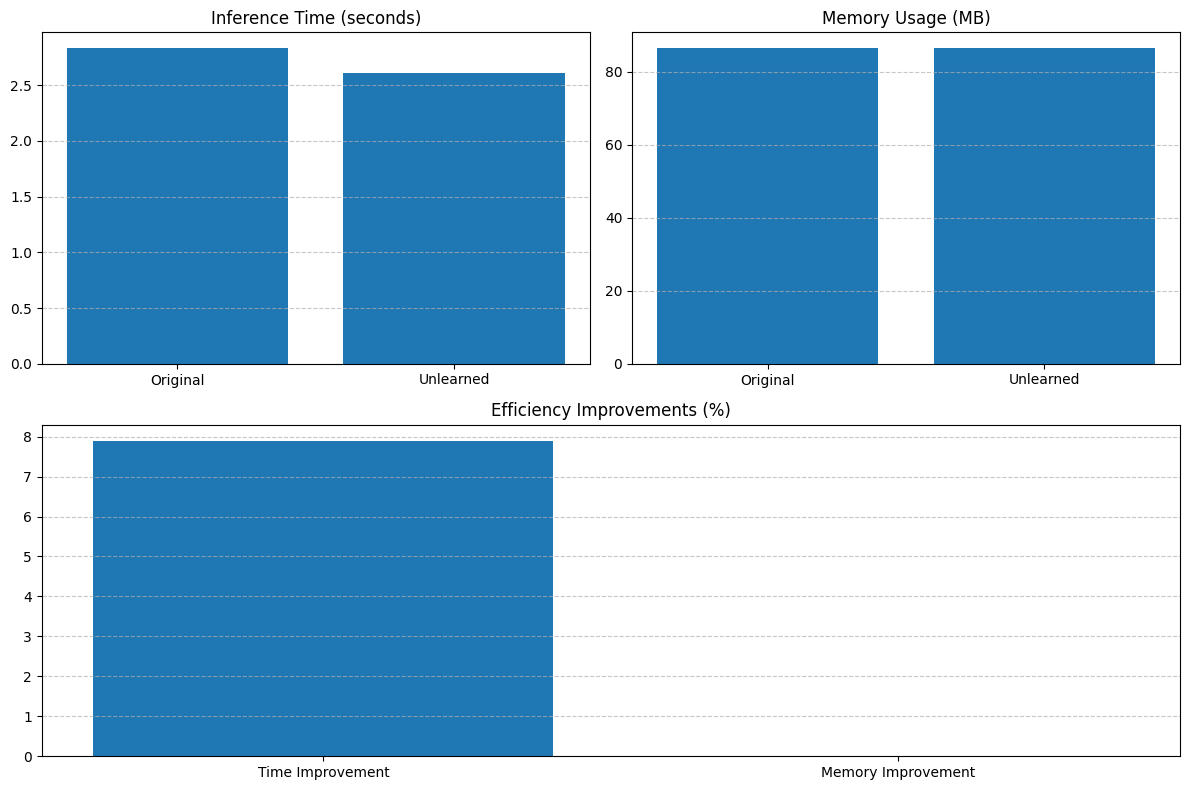

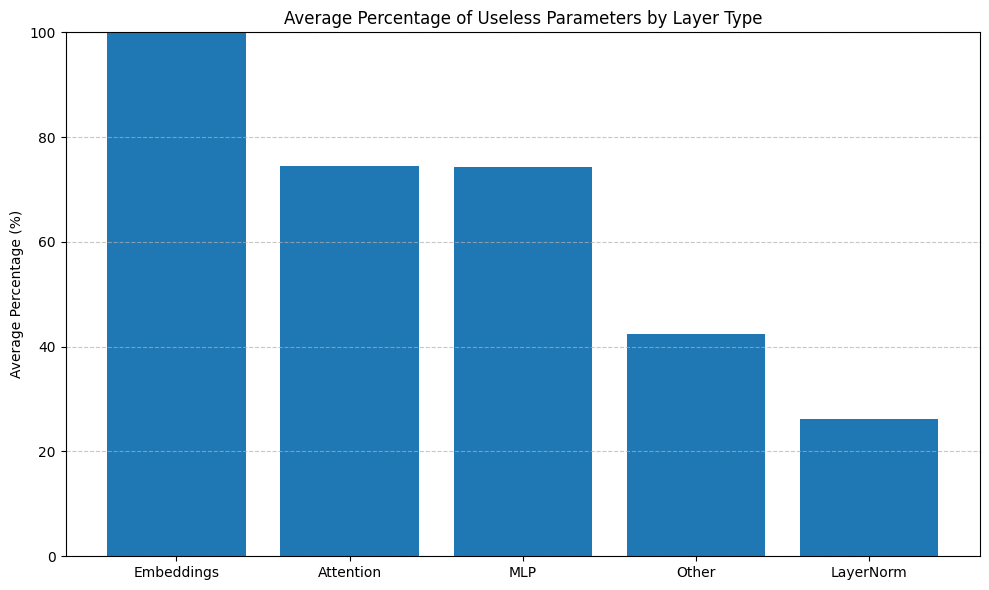

In [5]:
import torch
import numpy as np
from transformers import GPT2ForSequenceClassification, GPT2Tokenizer
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import copy
import os
import psutil

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

def unlearn_useless_parameters(model_path="gpt2_model_with_useless_params.pt"):
    """
    Load the saved model and unlearn (zero out) the useless parameters
    """
    print("Loading model with identified useless parameters...")
    checkpoint = torch.load(model_path)
    model_state_dict = checkpoint['model_state_dict']
    useless_params = checkpoint['useless_params']
    parameter_stats = checkpoint['parameter_stats']
    
    # Create a new model instance
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    tokenizer.pad_token = tokenizer.eos_token
    model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=2)
    model.config.pad_token_id = tokenizer.pad_token_id
    
    # Load the fine-tuned state
    model.load_state_dict(model_state_dict)
    
    # Create a copy for comparison
    original_model = copy.deepcopy(model)
    
    # Unlearn (zero out) useless parameters
    print("Unlearning useless parameters...")
    modified_state_dict = {}
    for name, param in model_state_dict.items():
        if name in useless_params:
            # Convert useless parameters mask to tensor
            mask = torch.tensor(~useless_params[name], dtype=param.dtype, device=param.device)
            mask = mask.reshape(param.shape)
            # Zero out useless parameters (element-wise multiplication)
            modified_param = param * mask
            modified_state_dict[name] = modified_param
        else:
            modified_state_dict[name] = param
    
    # Create the unlearned model
    unlearned_model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=2)
    unlearned_model.config.pad_token_id = tokenizer.pad_token_id
    unlearned_model.load_state_dict(modified_state_dict)
    
    # Count parameters that were actually zeroed out
    total_params = 0
    zeroed_params = 0
    for name, param in unlearned_model.named_parameters():
        if param.requires_grad:
            total_params += param.numel()
            zeroed_params += (param == 0).sum().item()
    
    print(f"Total parameters: {total_params:,}")
    print(f"Zeroed parameters: {zeroed_params:,} ({zeroed_params/total_params*100:.2f}%)")
    
    return original_model, unlearned_model, tokenizer, parameter_stats


def measure_inference_efficiency(original_model, unlearned_model, tokenizer, num_samples=100, sequence_length=512, batch_size=10):
    """
    Measure and compare inference efficiency of the original and unlearned models
    with batched processing to avoid OOM errors
    """
    print("\nMeasuring inference efficiency...")
    
    # Generate random input data
    input_ids = torch.randint(0, 50257, (num_samples, sequence_length))
    attention_mask = torch.ones_like(input_ids)
    
    # Move to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    original_model.to(device)
    unlearned_model.to(device)
    
    # Measure memory usage and inference time for original model
    original_memory = []
    original_times = []
    print("Testing original model...")
    
    # Warm-up run with small batch to avoid OOM
    with torch.no_grad():
        _ = original_model(input_ids=input_ids[:2].to(device), attention_mask=attention_mask[:2].to(device))
    
    for i in range(5):  # Run 5 trials
        # Clear GPU cache if using GPU
        if device.type == "cuda":
            torch.cuda.empty_cache()
        
        # Process data in batches to avoid OOM errors
        batch_times = []
        
        # Record memory before
        if device.type == "cuda":
            memory_before = torch.cuda.memory_allocated() / 1024**2  # MB
        else:
            memory_before = psutil.Process(os.getpid()).memory_info().rss / 1024**2  # MB
            
        # Process in batches
        start_time = time.time()
        with torch.no_grad():
            for j in range(0, num_samples, batch_size):
                batch_input_ids = input_ids[j:j+batch_size].to(device)
                batch_attention_mask = attention_mask[j:j+batch_size].to(device)
                _ = original_model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
                # Move results back to CPU to free GPU memory
                if device.type == "cuda":
                    torch.cuda.empty_cache()
        end_time = time.time()
        
        # Record memory after
        if device.type == "cuda":
            memory_after = torch.cuda.memory_allocated() / 1024**2  # MB
        else:
            memory_after = psutil.Process(os.getpid()).memory_info().rss / 1024**2  # MB
        
        original_memory.append(memory_after - memory_before)
        original_times.append(end_time - start_time)
    
    # Measure memory usage and inference time for unlearned model
    unlearned_memory = []
    unlearned_times = []
    print("Testing unlearned model...")
    
    # Warm-up run with small batch
    with torch.no_grad():
        _ = unlearned_model(input_ids=input_ids[:2].to(device), attention_mask=attention_mask[:2].to(device))
    
    for i in range(5):  # Run 5 trials
        # Clear GPU cache if using GPU
        if device.type == "cuda":
            torch.cuda.empty_cache()
        
        # Record memory before
        if device.type == "cuda":
            memory_before = torch.cuda.memory_allocated() / 1024**2  # MB
        else:
            memory_before = psutil.Process(os.getpid()).memory_info().rss / 1024**2  # MB
        
        # Process in batches
        start_time = time.time()
        with torch.no_grad():
            for j in range(0, num_samples, batch_size):
                batch_input_ids = input_ids[j:j+batch_size].to(device)
                batch_attention_mask = attention_mask[j:j+batch_size].to(device)
                _ = unlearned_model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
                # Move results back to CPU to free GPU memory
                if device.type == "cuda":
                    torch.cuda.empty_cache()
        end_time = time.time()
        
        # Record memory after
        if device.type == "cuda":
            memory_after = torch.cuda.memory_allocated() / 1024**2  # MB
        else:
            memory_after = psutil.Process(os.getpid()).memory_info().rss / 1024**2  # MB
        
        unlearned_memory.append(memory_after - memory_before)
        unlearned_times.append(end_time - start_time)
    
    # Calculate averages
    avg_original_time = np.mean(original_times)
    avg_unlearned_time = np.mean(unlearned_times)
    avg_original_memory = np.mean(original_memory)
    avg_unlearned_memory = np.mean(unlearned_memory)
    
    # Calculate improvements
    time_improvement = (avg_original_time - avg_unlearned_time) / avg_original_time * 100
    memory_improvement = (avg_original_memory - avg_unlearned_memory) / avg_original_memory * 100
    
    print(f"\nOriginal model - Average inference time: {avg_original_time:.4f}s, Memory usage: {avg_original_memory:.2f}MB")
    print(f"Unlearned model - Average inference time: {avg_unlearned_time:.4f}s, Memory usage: {avg_unlearned_memory:.2f}MB")
    print(f"Improvement - Time: {time_improvement:.2f}%, Memory: {memory_improvement:.2f}%")
    
    return {
        "original_time": avg_original_time,
        "unlearned_time": avg_unlearned_time,
        "original_memory": avg_original_memory,
        "unlearned_memory": avg_unlearned_memory,
        "time_improvement": time_improvement,
        "memory_improvement": memory_improvement
    }


     

def evaluate_accuracy(original_model, unlearned_model, tokenizer, validation_dataset, batch_size=8):
    """
    Evaluate and compare accuracy of the original and unlearned models
    """
    print("\nEvaluating model accuracy...")
    
    # Create validation dataloader
    val_loader = DataLoader(validation_dataset, batch_size=batch_size)
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    original_model.to(device)
    unlearned_model.to(device)
    
    # Evaluate original model
    original_model.eval()
    original_correct = 0
    original_total = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating original model"):
            batch = {k: v.to(device) for k, v in batch.items()}
            
            outputs = original_model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"]
            )
            
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            original_correct += (predictions == batch["labels"]).sum().item()
            original_total += batch["labels"].size(0)
    
    original_accuracy = original_correct / original_total
    
    # Evaluate unlearned model
    unlearned_model.eval()
    unlearned_correct = 0
    unlearned_total = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating unlearned model"):
            batch = {k: v.to(device) for k, v in batch.items()}
            
            outputs = unlearned_model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"]
            )
            
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            unlearned_correct += (predictions == batch["labels"]).sum().item()
            unlearned_total += batch["labels"].size(0)
    
    unlearned_accuracy = unlearned_correct / unlearned_total
    
    print(f"Original model accuracy: {original_accuracy:.4f}")
    print(f"Unlearned model accuracy: {unlearned_accuracy:.4f}")
    print(f"Accuracy difference: {(unlearned_accuracy - original_accuracy)*100:.2f}%")
    
    return original_accuracy, unlearned_accuracy

def visualize_results(parameter_stats, efficiency_metrics):
    """
    Create visualizations comparing the original and unlearned models
    """
    print("\nCreating visualizations...")
    
    # 1. Efficiency comparison
    plt.figure(figsize=(12, 8))
    
    # Time comparison
    plt.subplot(2, 2, 1)
    plt.bar(['Original', 'Unlearned'], 
            [efficiency_metrics['original_time'], efficiency_metrics['unlearned_time']])
    plt.title('Inference Time (seconds)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Memory comparison
    plt.subplot(2, 2, 2)
    plt.bar(['Original', 'Unlearned'], 
            [efficiency_metrics['original_memory'], efficiency_metrics['unlearned_memory']])
    plt.title('Memory Usage (MB)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Improvement percentages
    plt.subplot(2, 1, 2)
    plt.bar(['Time Improvement', 'Memory Improvement'], 
            [efficiency_metrics['time_improvement'], efficiency_metrics['memory_improvement']])
    plt.title('Efficiency Improvements (%)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('efficiency_comparison.png')
    
    # 2. Useless parameters distribution by layer type
    layer_types = {}
    for name in parameter_stats:
        # Extract layer type
        if 'attn' in name:
            layer_type = 'Attention'
        elif 'mlp' in name:
            layer_type = 'MLP'
        elif 'wte' in name or 'wpe' in name:
            layer_type = 'Embeddings'
        elif 'ln' in name:
            layer_type = 'LayerNorm'
        else:
            layer_type = 'Other'
        
        if layer_type not in layer_types:
            layer_types[layer_type] = []
        
        layer_types[layer_type].append(parameter_stats[name]['combined_percent'])
    
    # Calculate averages per layer type
    avg_by_type = {layer: np.mean(percentages) for layer, percentages in layer_types.items()}
    
    plt.figure(figsize=(10, 6))
    types = list(avg_by_type.keys())
    avgs = list(avg_by_type.values())
    
    # Sort by average percentage
    sorted_indices = np.argsort(avgs)[::-1]
    sorted_types = [types[i] for i in sorted_indices]
    sorted_avgs = [avgs[i] for i in sorted_indices]
    
    plt.bar(sorted_types, sorted_avgs)
    plt.title('Average Percentage of Useless Parameters by Layer Type')
    plt.ylabel('Average Percentage (%)')
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('useless_parameters_by_type.png')
    
    print("Visualizations saved as 'efficiency_comparison.png' and 'useless_parameters_by_type.png'")

# Function to load validation dataset based on the previous code
def load_validation_dataset(model_path="gpt2_model_with_useless_params.pt"):
    """
    Recreate the validation dataset used in the original code
    """
    from datasets import load_dataset
    from torch.utils.data import Dataset, random_split
    
    # Create a custom dataset class for IMDB
    class IMDbDataset(Dataset):
        def __init__(self, texts, labels, tokenizer, max_length=512):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_length = max_length
            
        def __len__(self):
            return len(self.labels)
            
        def __getitem__(self, idx):
            text = self.texts[idx]
            label = self.labels[idx]
            
            # Tokenize the text
            encoding = self.tokenizer(
                text,
                truncation=True,
                max_length=self.max_length,
                padding="max_length",
                return_tensors="pt"
            )
            
            # Convert to the expected format
            input_ids = encoding["input_ids"].squeeze()
            attention_mask = encoding["attention_mask"].squeeze()
            
            return {
                "input_ids": input_ids,
                "attention_mask": attention_mask,
                "labels": torch.tensor(label, dtype=torch.long)
            }
    
    # Setup tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    tokenizer.pad_token = tokenizer.eos_token
    
    # Load IMDB dataset
    print("Loading IMDB dataset...")
    dataset = load_dataset("imdb")
    
    # Create dataset with the same subset as in the original code
    train_texts = dataset["train"]["text"][:5000]
    train_labels = dataset["train"]["label"][:5000]
    
    # Create dataset
    full_dataset = IMDbDataset(train_texts, train_labels, tokenizer)
    
    # Split with the same ratio as in the original code
    train_size = int(0.9 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    _, val_dataset = random_split(full_dataset, [train_size, val_size])
    
    return val_dataset

# Main execution
if __name__ == "__main__":
    # Step 1: Unlearn useless parameters
    original_model, unlearned_model, tokenizer, parameter_stats = unlearn_useless_parameters()
    
    # Step 2: Measure inference efficiency
    efficiency_metrics = measure_inference_efficiency(original_model, unlearned_model, tokenizer)
    
    # Step 3: Evaluate accuracy
    val_dataset = load_validation_dataset()
    original_accuracy, unlearned_accuracy = evaluate_accuracy(original_model, unlearned_model, tokenizer, val_dataset)
    
    # Step 4: Visualize results
    visualize_results(parameter_stats, efficiency_metrics)
    
    # Step 5: Save the unlearned model
    torch.save({
        'model_state_dict': unlearned_model.state_dict(),
        'efficiency_metrics': efficiency_metrics,
        'original_accuracy': original_accuracy,
        'unlearned_accuracy': unlearned_accuracy
    }, 'gpt2_unlearned_model.pt')
    
    print("\nUnlearning complete. Unlearned model saved as 'gpt2_unlearned_model.pt'.")